<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fclassification/applications/classification/ner_tagging/NER%20tagging%20with%20Transformer-CRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ravirajag","key":"7c9b32c3baf1bd5e404db6e4e281fc5c"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus

 95% 25.0M/26.4M [00:01<00:00, 21.2MB/s]
100% 26.4M/26.4M [00:01<00:00, 23.7MB/s]


In [4]:
!unzip entity-annotated-corpus.zip

Archive:  entity-annotated-corpus.zip
  inflating: ner.csv                 
  inflating: ner_dataset.csv         


In [6]:
import time
import math
import random
import spacy
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from itertools import chain
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
datafile = 'ner_dataset.csv'

In [10]:
df = pd.read_csv(datafile, encoding="latin1", error_bad_lines=False)
df = df.fillna(method='ffill')

In [11]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [12]:
tags = list(df.Tag.unique())
tags

['O',
 'B-geo',
 'B-gpe',
 'B-per',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-art',
 'I-art',
 'I-per',
 'I-gpe',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

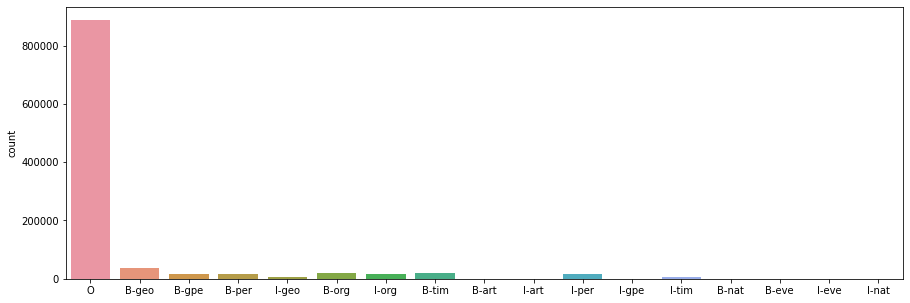

In [13]:
plt.figure(figsize=(15, 5))
sns.countplot(df.Tag.values)

In [14]:
num_tags = len(tags)
num_tags

17

In [15]:
agg_func = lambda s: [(w, t) for w, p, t in zip(s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist())]
group = df.groupby("Sentence #").apply(agg_func)
lines = [s for s in group]

In [16]:
lines[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [19]:
sentences = [['<start>'] + [tokens[0] for tokens in line] + ['<end>'] for line in lines]
tags = [['<start>'] + [tokens[1] for tokens in line] + ['<end>'] for line in lines]

In [20]:
len(sentences), len(tags)

(47959, 47959)

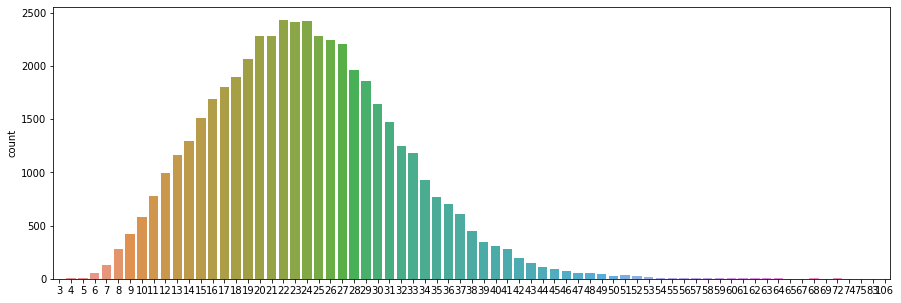

In [21]:
sen_lengths = [len(sent) for sent in sentences]
plt.figure(figsize=(15, 5))
sns.countplot(sen_lengths)

In [93]:
train_sentences, valid_sentences, train_tags, valid_tags = train_test_split(sentences, tags, test_size=0.2, random_state=42)
valid_sentences, test_sentences, valid_tags, test_tags = train_test_split(valid_sentences, valid_tags, test_size=0.5, random_state=42)
len(train_sentences), len(valid_sentences), len(test_sentences)

(38367, 4796, 4796)

In [23]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [28]:
def build_vocab(data, threshold=5, is_tags=False):
    counter = Counter(chain(*data))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    if not is_tags:
        vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab


In [29]:
words_vocab = build_vocab(train_sentences)
tags_vocab = build_vocab(train_tags, is_tags=True)
len(tags_vocab)

20

In [30]:
tags_vocab.word2idx.keys()

dict_keys(['<pad>', '<start>', '<end>', 'B-geo', 'I-geo', 'O', 'B-tim', 'I-tim', 'B-org', 'B-per', 'I-per', 'B-gpe', 'I-org', 'B-art', 'B-eve', 'I-eve', 'I-gpe', 'B-nat', 'I-nat', 'I-art'])

In [35]:
class NERDataset(data.Dataset):
    def __init__(self, sentences, tags):
        self.sentences = sentences
        self.tags = tags
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        sentence = self.sentences[item]
        tag = self.tags[item]
        tokens, tags = [], []

        for word, t in zip(sentence, tag):
            tokens.append(words_vocab(word))
            tags.append(tags_vocab(t))

        return torch.LongTensor(tokens), torch.LongTensor(tags)

In [94]:
train_dataset = NERDataset(train_sentences, train_tags)
valid_dataset = NERDataset(valid_sentences, valid_tags)
test_dataset = NERDataset(test_sentences, test_tags)

In [95]:
train_sentences[0], train_tags[0], train_dataset[0]

(['<start>',
  'South',
  'Korea',
  "'s",
  'government',
  'Tuesday',
  'also',
  'unveiled',
  'a',
  'so-called',
  'Green',
  'New',
  'Job',
  'Creation',
  'Plan',
  ',',
  'expected',
  'to',
  'create',
  '9,60,000',
  'new',
  'jobs',
  '.',
  '<end>'],
 ['<start>',
  'B-geo',
  'I-geo',
  'O',
  'O',
  'B-tim',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  '<end>'],
 (tensor([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  3,  3, 15, 16, 17, 18,
          19,  3, 20, 21, 22,  2]),
  tensor([1, 3, 4, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2])))

In [96]:
BATCH_SIZE = 128

In [97]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[0]), reverse=True)
    sentences, tags = zip(*data)

    # Merge questions (from tuple of 1D tensor to 2D tensor).
    sent_lengths = [len(sent) for sent in sentences]
    inputs = torch.zeros(len(sentences), max(sent_lengths)).long()
    labels = torch.zeros(len(sentences), max(sent_lengths)).long()
    
    for i, (sent, lab) in enumerate(zip(sentences, tags)):
        end = sent_lengths[i]
        inputs[i, :end] = sent[:end]
        labels[i, :end] = lab[:end]

    return inputs, labels, sent_lengths

In [98]:
train_data_loader = data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_data_loader = data.DataLoader(valid_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_data_loader = data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [99]:
sample = next(iter(train_data_loader))
sample[0].shape, sample[1].shape, len(sample[2])

(torch.Size([128, 42]), torch.Size([128, 42]), 128)

In [44]:
class PositionalEncoding(nn.Module):
    """
    Implements the positional encoding.
    There are other ways of implementing positional encoding.
    Below mentioned is the way where the positional encoding is fixed.
    Other way is to make that as a learnable using: nn.Embedding(max_len, d_model)
    Paper claims there is not much of a difference between either ways.
    """
    def __init__(self, d_model, dropout, max_len=1000):
        super().__init__()

        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000) / d_model))

        # pe(pos, 2i) = sin(pos / (10000 ^ (2i/d_model)))
        pe[:, 0::2] = torch.sin(position * div_term)

        # pe(pos, 2i+1) = cos(pos / (10000 ^ (2i/d_model)))
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        # pe => [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x => [batch_size, seq_len, d_model]
        
        # get the positional embeddings of word and add it
        x = x + self.pe[:, :x.shape[1], :]
        # x => [batch_size, seq_len, d_model]

        return self.dropout(x)

In [61]:
class SelfAttention(nn.Module):
    """
    Implements the self-attention layer.
    This is the core of the transformer model.
    There are three kinds of self-attention in transformer:
        > Encoder - Encoder: Does the self-attention on the src sentence
        > Decoder - Decoder: Does the self-attention on the trg sentence
        > Encoder - Decoder: Attends to the src sentence while decoding a particular word
    """
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()

        self.d_model = d_model
        self.n_heads = n_heads

        assert d_model % n_heads == 0, "Number of attention heads must be a factor of d_model"
        # in paper d_model = 512, n_heads = 8

        # query, key, value weight matrices
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        self.drop = nn.Dropout(dropout)

        # linear layer to be applied after concating the attention head outputs
        self.fc = nn.Linear(d_model, d_model)

        # scale factor to be applied in calculation of self-attention
        self.scale = torch.sqrt(torch.FloatTensor([d_model // n_heads])).to(device)

    def forward(self, query, key, value, mask=None):
        # query => [batch_size, seq_len, d_model]
        # key => [batch_size, seq_len, d_model]
        # value => [batch_size, seq_len, d_model]
        # mask => [batch_size, 1, seq_len(query), seq_len(key)]

        batch_size = query.shape[0]
        hid_dim = query.shape[2]
        assert hid_dim == self.d_model, "Hidden dimensions must match"

        Q = self.w_q(query)
        K = self.w_k(key)
        V = self.w_v(value)
        # Q, K, V => [batch_size, seq_len, d_model]

        Q = Q.view(batch_size, -1, self.n_heads, hid_dim // self.n_heads).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, hid_dim // self.n_heads).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, hid_dim // self.n_heads).permute(0, 2, 1, 3)
        # Q, K, V => [batch_size, n_heads, seq_len, head_dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        # energy => [batch_size, n_heads, seq_len(query), seq_len(key)]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim=-1)
        attention = self.drop(attention)
        # attention => [batch_size, n_heads, seq_len(query), seq_len(key)]

        weighted = torch.matmul(attention, V)
        # weighted => [batch_size, n_heads, seq_len(query), head_dim]

        weighted = weighted.permute(0, 2, 1, 3)
        # weighted => [batch_size, seq_len(query), n_heads, head_dim]

        weighted = weighted.contiguous()
        weighted = weighted.view(batch_size, -1, hid_dim)
        # weighted => [batch_size, seq_len(query), d_model]

        output = self.fc(weighted)
        # output => [batch_size, seq_len(query), d_model]

        return output, attention

In [46]:
class PositionWiseFeedForward(nn.Module):
    """
    Implements the Position wise feed forward layer.
    It is a simple linear layer that project the input to higher dimension
    and then back project to the dimension feasible to the model.
    """
    def __init__(self, d_model, hidden_dim, dropout):
        super().__init__()

        self.fc1 = nn.Linear(d_model, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        # input => [batch_size, seq_len, d_model]

        x = self.dropout(torch.relu(self.fc1(input)))
        # x => [batch_size, seq_len, hidden_dim]

        out = self.fc2(x)
        # out => [batch_size, seq_len, d_model]

        return out

In [62]:
class EncoderLayer(nn.Module):
    """
    Implement the single encoder block.
    There are 6 encoder blocks in transformer (according to the paper).
    Each encoder block encapsulates self-attention, positionwise feedforward layer
    and then the residual connections across each layer.
    """
    def __init__(self, d_model, n_heads, pff_dim, dropout):
        super().__init__()

        self.self_attention_layer_norm = nn.LayerNorm(d_model)
        self.pff_layer_norm = nn.LayerNorm(d_model)
        self.self_attention = SelfAttention(d_model, n_heads, dropout)
        self.pff = PositionWiseFeedForward(d_model, pff_dim, dropout)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src, src_mask):
        # src => [batch_size, seq_len, d_model]
        # src_mask => [batch_size, 1(n_heads), seq_len(query), seq_len(key)]

        # self_attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        # residual connection with layer norm
        src = self.self_attention_layer_norm(src + self.dropout(_src))
        # src => [batch_size, seq_len, d_model]

        # positionwise feed forward
        _src = self.pff(src)

        # residual connection with layer norm
        src = self.pff_layer_norm(src + self.dropout(_src))
        # src => [batch_size, seq_len, d_model]

        return src

In [63]:
class Encoder(nn.Module):
    """
    Implements the encoder.
    It takes the input and applies the word embedding, position embedding
    for each word and then it is passed through the encoder blocks.
    """
    def __init__(self, input_dim, d_model, n_layers, n_heads, pff_dim, dropout):
        super().__init__()

        self.tok_embedding = nn.Embedding(input_dim, d_model)
        self.pos_embedding = PositionalEncoding(d_model, dropout)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, pff_dim, dropout) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src, src_mask):
        # src => [batch_size, seq_len]
        # src_mask => [batch_size, 1, seq_len(query), seq_len(key)]

        word_embedding = self.tok_embedding(src)
        # word_embedding => [batch_size, seq_len, d_model]

        position_embedding = self.pos_embedding(word_embedding)

        src = self.dropout(position_embedding)

        for layer in self.layers:
            src = layer(src, src_mask)
            # src => [batch_size, seq_len, d_model]

        return src

In [128]:
class Transformer(nn.Module):
    """
    Implements the transformer.
    It encapsulates the encoder and decoder. Inputs to encoder & decoder are padded
    to make batch processing feasible. While performing attention certain parts of
    the input need not be attended. This will taken care by input masks. Also while
    decoding a word at a certain position, it can only attend to the inputs present
    to the left side of it, not the right(future) inputs. So the decoder input masking
    contains an extra step, for each input it masks the inputs right-side of it.
    """
    def __init__(self, encoder, src_pad_idx, d_model, tag_vocab_size, tag_start_token):
        super().__init__()

        self.encoder = encoder
        self.decoder = nn.Linear(d_model, tag_vocab_size)
        self.transition = nn.Parameter(torch.rand(tag_vocab_size, tag_vocab_size))
        self.src_pad_idx = src_pad_idx
        self.tag_start_token = tag_start_token
        self.tag_vocab_size = tag_vocab_size

    def make_src_mask(self, src):
        # src => [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2).to(device)
        # src_mask => [batch_size, 1, 1, src_len]

        return src_mask

    def forward(self, src, tags):
        # src => [batch_size, src_len]
        # tags => [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        # src_mask => [batch_size, 1, 1, src_len]

        enc_src = self.encoder(src, src_mask)
        # enc_src => [batch_size, src_len, d_model]

        emission_scores = self.decoder(enc_src)
        
        mask = (src != self.src_pad_idx).to(device)
        loss = self.vitebri_loss(tags, mask, emission_scores)
        # loss => [batch_size]

        return loss
    
    def vitebri_loss(self, tags, mask, emit_scores):
        # tags => [batch_size, seq_len]
        # mask => [batch_size, seq_len]
        # emit_scores => [seq_len, batch_size, tag_size]

        batch_size, sent_len = tags.shape

        # calculate the ground truth score
        score = torch.gather(emit_scores, 2, tags.unsqueeze(2)).squeeze(2)
        # emission scores of actual tags
        # score => [batch_size, seq_len]

        # add the transition scores to the emission scores
        # ignore the start token tag score
        score[:, 1:] += self.transition[tags[:, :-1], tags[:, 1:]]

        # consider only the scores of actual tokens not the padded
        gold_scores = (score * mask.type(torch.float)).sum(dim=1)
        # gold_scores => [batch_size]

        # calculate the scores of the partition (Z)
        # tensor to hold the accumulated sequence scores at each time step
        # at the inital time step score will be on dim=0
        scores_upto_t = emit_scores[:, 0].unsqueeze(1)
        # scores_upto_t => [batch_size, 1, tag_size]

        for i in range(1, sent_len):
            # get the current batch_size
            batch_t = mask[:, i].sum()

            # get the accumulated scores till now (only the current batch size)
            scores_unpad = scores_upto_t[:batch_t]
            # scores_unpad => [batch_t, 1, tag_size]

            # add the transition scores for this time step
            scores_with_trans = emit_scores[:batch_t, i].unsqueeze(1) + self.transition
            # scores_with_trans => [batch_t, tag_size, tag_size]

            # add to the accumulation
            sum_scores = scores_unpad.transpose(1, 2) + scores_with_trans
            # sum_scores => [batch_t, tag_size, tag_size]
            
            # apply the following to overcome the overflow problems
            # since the exp(some_big_number) will cause issues 
            # log(Σ exp(z_k)) = max(z) + log(Σ exp(z_k - max(z)))
            # log(Σ exp(z_k)) = log(Σ exp(z_k - c + c))
            #                 = log(Σ exp(z_k - c) * exp(c))
            #                 = log(Σ exp(z_k - c)) + log(exp(c))
            #                 = log(Σ exp(z_k - c)) + c
            # by taking c as max(z)
            # log(Σ exp(z_k)) = max(z) + log(Σ exp(z_k - max(z))) [log_sum_exp]
            # get the maximum score of the current time step
            max_t = sum_scores.max(dim=1)[0].unsqueeze(1)
            # max_t => [batch_t, 1, tag_size]

            sum_scores = sum_scores - max_t
            # sum_scores => [batch_t, tag_size, tag_size]

            scores_t = max_t + torch.logsumexp(sum_scores, dim=1).unsqueeze(1)
            # scores_t => [batch_t, 1, tag_size]

            # update the accumulation scores
            scores_upto_t = torch.cat((scores_t, scores_upto_t[batch_t:]), dim=0)
            # scores_upto_t => [batch_size, 1, tag_size]
        
        final_scores = scores_upto_t.squeeze(1)
        # final_scores => [batch_size, tag_size]

        max_final_scores = final_scores.max(dim=-1)[0]
        # max_final_scores => [batch_size]

        predicted_scores = max_final_scores + torch.logsumexp(final_scores - max_final_scores.unsqueeze(1), dim=1)
        # predicted_scores => [batch_size]

        vitebri_loss = predicted_scores - gold_scores
        # vitebri_loss => [batch_size]

        return vitebri_loss
    
    def predict(self, src, lengths):
        # sentences => [batch_size, seq_len]

        batch_size = src.size(0)

        src_mask = self.make_src_mask(src)
        # src_mask => [batch_size, 1, 1, src_len]

        enc_src = self.encoder(src, src_mask)
        # enc_src => [batch_size, src_len, d_model]

        emission_scores = self.decoder(enc_src)
        
        mask = (src != self.src_pad_idx).to(device)
        # mask => [batch_size, seq_len]

        # to store the tags predicted at each time step
        # since at the begining every tag is start tag create the list with start tags
        tags = [[[self.tag_start_token] for _ in range(self.tag_vocab_size)]] * batch_size
        # tags => [batch_size, tag_size, 1]

        scores_upto_t = emission_scores[:, 0].unsqueeze(1)
        # scores_upto_t => [batch_size, 1, tag_size]

        for i in range(1, max(lengths)):
            # get the current batch_size
            batch_t = mask[:, i].sum()

            # get the accumulated scores till now (only the current batch size)
            scores_unpad = scores_upto_t[:batch_t]
            # scores_unpad => [batch_t, 1, tag_size]

            # add the transition scores for this time step
            scores_with_trans = emission_scores[:batch_t, i].unsqueeze(1) + self.transition
            # scores_with_trans => [batch_t, tag_size, tag_size]

            # add to the accumulation
            sum_scores = scores_unpad.transpose(1, 2) + scores_with_trans
            # sum_scores => [batch_t, tag_size, tag_size]

            max_scores_t, max_ids_t = torch.max(sum_scores, dim=1)
            max_ids_t = max_ids_t.tolist()
            # max_scores_t => [batch_t, tag_size]
            # max_ids_t => [batch_t, tag_size]

            # add the current time step predicted tags 
            tags[:batch_t] = [[tags[b][k] + [j] for j, k in enumerate(max_ids_t[b])] for b in range(batch_t)]
            
            # update the accumulation scores
            scores_upto_t = torch.cat((max_scores_t.unsqueeze(1), scores_upto_t[batch_t:]), dim=0)
            # scores_upto_t => [batch_size, tag_size]

        scores = scores_upto_t.squeeze(1)
        # scores => [batch_size, tag_size]

        _, max_ids = torch.max(scores, dim=1)
        max_ids = max_ids.tolist()
        # max_ids => [batch_size]

        # tags => [batch_size, tag_size, seq_len]
        tags = [tags[b][k] for b, k in enumerate(max_ids)]
        # tags => [batch_size, seq_len]

        return tags



In [129]:
d_model = 128
pff_dim = 256
n_heads = 8
n_layers = 3
input_dim = len(words_vocab)
output_dim = 15
dropout = 0.4
src_pad_idx = words_vocab('<pad>')
tag_start_id = tags_vocab('<start>')
output_dim = len(tags_vocab)

encoder = Encoder(input_dim, d_model, n_layers, n_heads, pff_dim, dropout)
model = Transformer(encoder, src_pad_idx, d_model, output_dim, tag_start_id)
model = model.to(device)

In [114]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)

model.apply(init_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(9620, 128)
    (pos_embedding): PositionalEncoding(
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attention_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (pff_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (self_attention): SelfAttention(
          (w_q): Linear(in_features=128, out_features=128, bias=True)
          (w_k): Linear(in_features=128, out_features=128, bias=True)
          (w_v): Linear(in_features=128, out_features=128, bias=True)
          (drop): Dropout(p=0.4, inplace=False)
          (fc): Linear(in_features=128, out_features=128, bias=True)
        )
        (pff): PositionWiseFeedForward(
          (fc1): Linear(in_features=128, out_features=256, bias=True)
          (fc2): Linear(in_features=256, out_features=128, bias=True)
          (dropout): Dropout(p=0.4, inplace=False

In [115]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 1,631,780 trainable parameters


In [116]:
optimizer = optim.Adam(model.parameters())

In [117]:
def categorical_accuracy(preds, y, tag_pad_idx):
    max_preds = preds.argmax(dim = 1, keepdim = True)
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]]).to(device)

In [118]:
def train(model, iterator, optimizer, clip):
    model.train()
    epoch_loss = 0

    for batch in iterator:
        text = batch[0].to(device)
        tags = batch[1].to(device)
        # text => [seq_len, batch_size]
        # tags => [seq_len, batch_size]

        optimizer.zero_grad()

        batch_loss = model(text, tags)

        loss = torch.mean(batch_loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)


In [119]:
def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in iterator:
            text = batch[0].to(device)
            tags = batch[1].to(device)
            # text => [seq_len, batch_size]
            # tags => [seq_len, batch_size]

            batch_loss = model(text, tags)
            loss = torch.mean(batch_loss)
            
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [120]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [121]:
N_EPOCHS = 20
CLIP = 2
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss = train(model, train_data_loader, optimizer, CLIP)
    valid_loss = evaluate(model, valid_data_loader)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')


Epoch: 01 | Epoch Time: 0m 38s
	Train Loss: 26.499 | Val. Loss: 19.326
Epoch: 02 | Epoch Time: 0m 37s
	Train Loss: 18.042 | Val. Loss: 14.634
Epoch: 03 | Epoch Time: 0m 37s
	Train Loss: 14.283 | Val. Loss: 13.913
Epoch: 04 | Epoch Time: 0m 37s
	Train Loss: 13.602 | Val. Loss: 13.400
Epoch: 05 | Epoch Time: 0m 37s
	Train Loss: 13.187 | Val. Loss: 13.033
Epoch: 06 | Epoch Time: 0m 37s
	Train Loss: 9.962 | Val. Loss: 7.210
Epoch: 07 | Epoch Time: 0m 37s
	Train Loss: 6.476 | Val. Loss: 5.110
Epoch: 08 | Epoch Time: 0m 37s
	Train Loss: 5.430 | Val. Loss: 4.831
Epoch: 09 | Epoch Time: 0m 37s
	Train Loss: 5.084 | Val. Loss: 4.634
Epoch: 10 | Epoch Time: 0m 37s
	Train Loss: 4.806 | Val. Loss: 4.281
Epoch: 11 | Epoch Time: 0m 37s
	Train Loss: 4.532 | Val. Loss: 4.039
Epoch: 12 | Epoch Time: 0m 37s
	Train Loss: 4.293 | Val. Loss: 3.800
Epoch: 13 | Epoch Time: 0m 37s
	Train Loss: 4.073 | Val. Loss: 3.653
Epoch: 14 | Epoch Time: 0m 37s
	Train Loss: 3.788 | Val. Loss: 3.235
Epoch: 15 | Epoch Time: 

In [130]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [123]:
test_loss = evaluate(model, test_data_loader)
print(f'Test Loss: {test_loss:.3f}')


Test Loss: 2.975


In [144]:
def inference(sentence):
    if isinstance(sentence, str):
        tokens = [words_vocab('<start>')] + sentence.split() + [words_vocab('<end>')]
    else:
        tokens = sentence
    
    # numericalize
    token_ids = [words_vocab(tok) for tok in tokens]
    # seq length
    sent_length = [len(token_ids)]

    # create tensors
    sent_tensor = torch.LongTensor(token_ids).to(device)
    sent_tensor = sent_tensor.unsqueeze(0)
    # sent_tensor => [1, seq_len]

    model.eval()
    with torch.no_grad():
        predictions = model.predict(sent_tensor, sent_length)
    
    predictions = predictions[0]
    predicted_tags = []
    for i in predictions:
        predicted_tags.append(tags_vocab.idx2word[i])
    
    return tokens, predicted_tags

In [145]:
sentence = test_sentences[0]
actual_tags = test_tags[0]
tokens, predicted_tag_ids = inference(sentence)

print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")
for token, pred_tag, actual_tag in zip(tokens, predicted_tag_ids, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")

Pred. Tag	Actual Tag	Correct?	Token

<start>		<start>		✔		<start>
O		O		✔		The
O		O		✔		office
O		O		✔		of
O		O		✔		the
B-gpe		B-gpe		✔		Israeli
O		O		✔		prime
O		O		✔		minister
O		O		✔		says
O		O		✔		a
O		O		✔		visit
O		O		✔		to
B-geo		B-geo		✔		Israel
O		O		✔		by
O		O		✔		the
O		O		✔		foreign
O		O		✔		ministers
O		O		✔		of
B-geo		B-gpe		✘		Egypt
O		O		✔		and
B-gpe		B-gpe		✔		Jordan
O		O		✔		will
O		O		✔		take
O		O		✔		place
B-tim		B-tim		✔		July
I-tim		I-tim		✔		25
O		O		✔		,
O		O		✔		not
O		O		✔		this
O		O		✔		week
O		O		✔		as
O		O		✔		previously
O		O		✔		planned
O		O		✔		.
<end>		<end>		✔		<end>
